In [1]:
import os

# in the case of a workstation with multiple GPU devices
# we can select only one of them for use in this notebook
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# NoProp JAX/Equinox Implementation Demo

This notebook demonstrates the JAX/Equinox implementation of the NoProp algorithm - a novel training method for neural networks without back-propagation or forward-propagation.

## Setup and Installation

First, let's install the required dependencies and import the NoProp library:

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax

# Import our NoProp implementation
import nullaprop as nop
from nullaprop.models import init_noprop_model
from nullaprop.utils import load_data, plot_training_curves
from nullaprop.training import compute_loss, create_train_state, train_step
from nullaprop.inference import inference_ct_euler, inference_ct_heun

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print(f"NullaProp version: {nop.__version__}")

JAX version: 0.8.0
JAX devices: [CudaDevice(id=0)]
NullaProp version: 0.1.0


## 1. Quick benchmarks

Let's run a quick experiment on MNIST to see NoProp in action:

In [3]:
key = jax.random.PRNGKey(42)
    
key, model_key = jax.random.split(key)
embed_dim = 256
model = init_noprop_model(
    key=model_key,
    num_classes=10,
    embed_dim=embed_dim, # Default from new init, also sets CNN's feature_dim
)

batch_size = 2048
train_iter, test_iter = load_data("mnist", batch_size=batch_size)

for x, y in train_iter:
    model.cnn(x)

    key, t_key, z_key = jax.random.split(key, 3)
    dummy_t_continuous = jax.random.uniform(t_key, (batch_size, 1))
    # Dummy noisy z, actual noise generation is part of loss/inference
    dummy_z_noisy = jax.random.normal(z_key, (batch_size, model.embed_dim))
    
    logits = model(x, dummy_z_noisy, dummy_t_continuous)

    key, loss_key = jax.random.split(key)
    loss, _ = compute_loss(model, x, y, loss_key, eta=1.0)
    print(f"Loss: {loss:.4f}")

    %timeit jax.block_until_ready(compute_loss(model, x, y, loss_key, eta=1.0))

    # Test inference (Euler)
    print("\nTesting Euler inference...")
    key, inf_key = jax.random.split(key)
    inference_ct_euler(model, x, inf_key, T_steps=5) # Small T_steps for test
    %timeit jax.block_until_ready(inference_ct_euler(model, x, inf_key, T_steps=10))


    # Test inference (Heun)
    print("\nTesting Heun inference...")
    key, inf_key_heun = jax.random.split(key)
    inference_ct_heun(model, x, inf_key_heun, T_steps=5) # Small T_steps
    %timeit jax.block_until_ready(inference_ct_heun(model, x, inf_key, T_steps=10))

    optimizer = optax.adamw(learning_rate=1e-3) # Optimizer passed to train_epoch
    key, state_key = jax.random.split(key)
    state = create_train_state(model, optimizer, key=state_key)
    
    print("\nTesting train step...")
    train_step(state, x, y, optimizer, eta=1.0)
    %timeit jax.block_until_ready( train_step(state, x, y, optimizer, eta=1.0) )
    break

Loss: 2.5430
69.9 ms ± 3.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Testing Euler inference...
29.1 ms ± 133 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)

Testing Heun inference...
33.4 ms ± 121 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)

Testing train step...
25.8 ms ± 96.8 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 2. MNIST Experiment

Let's run a quick experiment on MNIST to see NoProp in action:

NOPROP MNIST EXPERIMENT
Loading MNIST dataset...
Initializing NoProp model (CT version)...
Model initialized: embed_dim=256, num_classes=10

Starting training for 50 epochs...


100%|██████████| 50/50 [01:39<00:00,  2.00s/it, loss=0.0001]



Final evaluation...

Final accuracy: 0.9917
Final loss: 0.0359


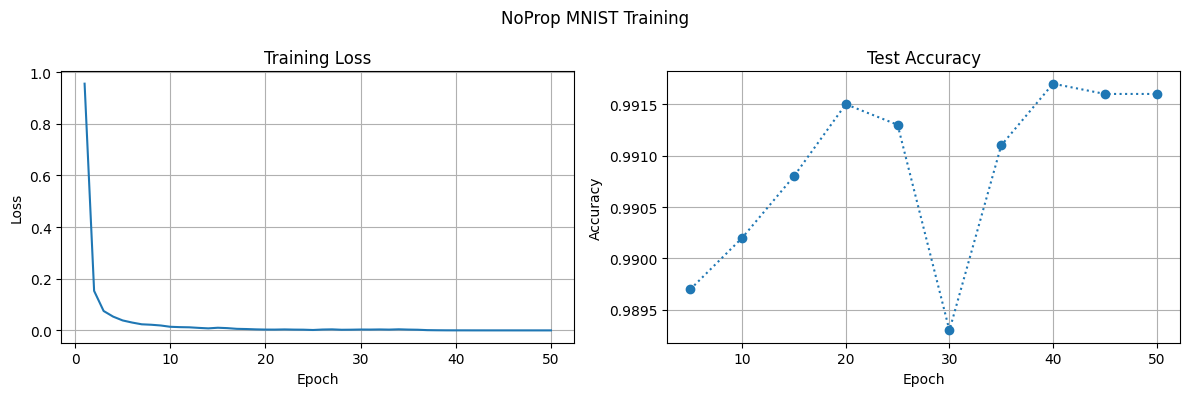

0.99170005 0.035931148


In [4]:
results = nop.run_experiment(
    'mnist',
    epochs=50,
    seed=137,
    T = 100
)

print(f"\nFinal accuracy: {results['final_accuracy']:.4f}")
print(f"Final loss: {results['final_loss']:.4f}")

# Plot training curves
plot_training_curves(results['losses'], results['accuracies'], "NoProp MNIST Training")
print(results['final_accuracy'], results['final_loss'])

## 3. CIFAR10 Experiment

Let's run an experiment on CIFAR10:

NOPROP MNIST EXPERIMENT
Loading CIFAR10 dataset...
Initializing NoProp model (CT version)...
Model initialized: embed_dim=256, num_classes=10

Starting training for 50 epochs...


100%|██████████| 50/50 [01:41<00:00,  2.04s/it, loss=0.0014]



Final evaluation...

Final accuracy: 0.7068
Final loss: 1.6758


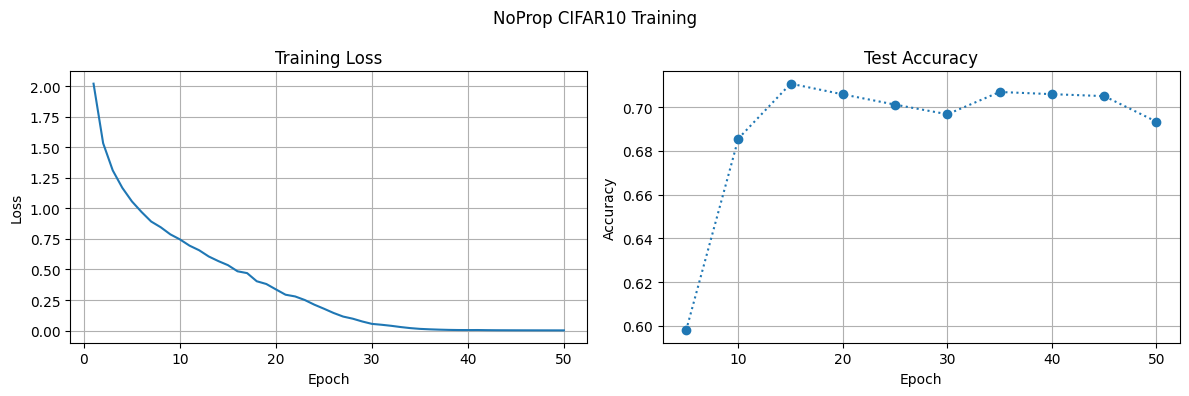

0.70680004 1.6757891


In [5]:
results = nop.run_experiment(
    'cifar10',
    epochs=50,
    seed=138,
    T=100
)

print(f"\nFinal accuracy: {results['final_accuracy']:.4f}")
print(f"Final loss: {results['final_loss']:.4f}")

# Plot training curves
plot_training_curves(results['losses'], results['accuracies'], "NoProp CIFAR10 Training")
print(results['final_accuracy'], results['final_loss'])

## 4. CIFAR100 Experiment

Let's run aa experiment on CIFAR100:

NOPROP MNIST EXPERIMENT
Loading CIFAR100 dataset...
Initializing NoProp model (CT version)...
Model initialized: embed_dim=256, num_classes=100

Starting training for 50 epochs...


100%|██████████| 50/50 [01:39<00:00,  2.00s/it, loss=0.0101]



Final evaluation...

Final accuracy: 0.3760
Final loss: 3.7292


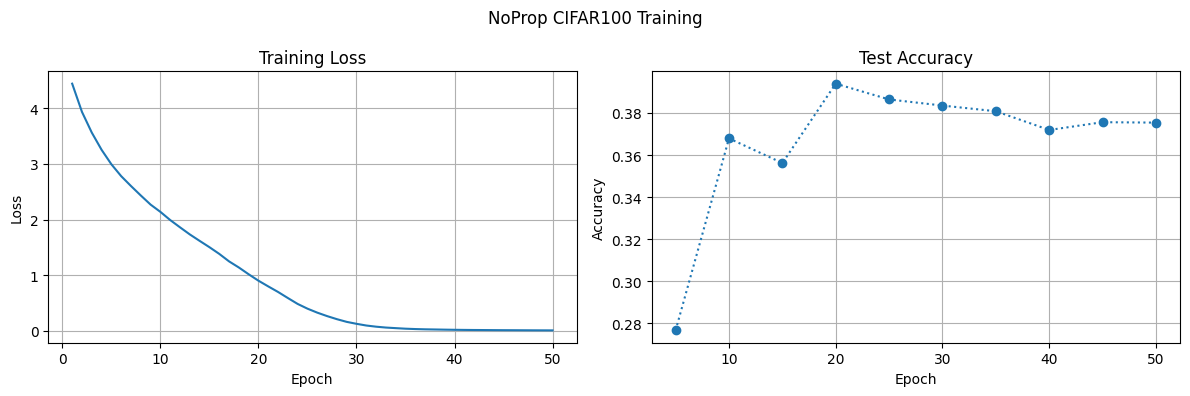

0.37600002 3.7292159


In [6]:
results = nop.run_experiment(
    'cifar100',
    epochs=50,
    seed=139,
    T=100
)

print(f"\nFinal accuracy: {results['final_accuracy']:.4f}")
print(f"Final loss: {results['final_loss']:.4f}")

# Plot training curves
plot_training_curves(results['losses'], results['accuracies'], "NoProp CIFAR100 Training")
print(results['final_accuracy'], results['final_loss'])

## 6. Performance Benchmarking

Let's benchmark the performance with different configurations:

In [7]:
# Benchmark different configurations
print("Benchmarking performance...")
benchmark_results = nop.benchmark_performance(
    dataset="mnist",
    batch_sizes=[256, 512, 1024],
    T_values=[40, 80],
    seed=42
)

Benchmarking performance...
Benchmarking performance on MNIST...

batch_size=256
Train time: 1.4636s

Testing T=40
  Inference time Euler: 0.0169s
  Inference time Heun: 0.0205s

Testing T=80
  Inference time Euler: 0.0324s
  Inference time Heun: 0.0390s

batch_size=512
Train time: 1.7748s

Testing T=40
  Inference time Euler: 0.0292s
  Inference time Heun: 0.0348s

Testing T=80
  Inference time Euler: 0.0568s
  Inference time Heun: 0.0676s

batch_size=1024
Train time: 1.9734s

Testing T=40
  Inference time Euler: 0.0546s
  Inference time Heun: 0.0630s

Testing T=80
  Inference time Euler: 0.1078s
  Inference time Heun: 0.1250s
